| train_loss: 1.32e-01 | test_loss: 1.53e-01 | reg: 1.24e+01 | : 100%|█| 20/20 [00:08<00:00,  2.30it


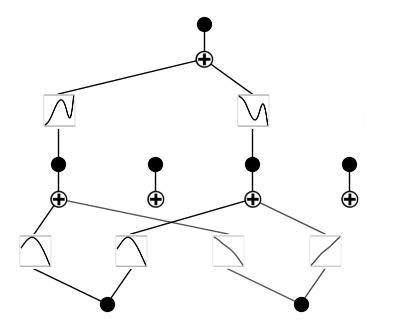

In [1]:
import torch
from kan import create_dataset
from kan.custom_multkan_ddp import MultKAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.sin(2 * x[:, [0]]) * x[:, [1]]
dataset = create_dataset(f,
                         ranges=[-torch.pi, torch.pi],
                         n_var=2,
                         train_num=3000,
                         test_num=300,
                         device=device,
                         normalize_label=True,
                         normalize_input=True,
                         )

model = MultKAN(width=[2,4,1], grid=3, k=3, seed=0, device=device)
fit_kwargs = {'opt': 'LBFGS', 'lr': 1, 'lamb': 0.01,
              'lamb_entropy': 0.1, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5,}
model.fit(dataset, steps=20, **fit_kwargs)
model.plot()

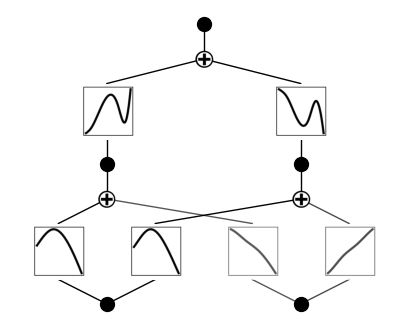

In [2]:
model = model.prune(edge_th=0.05, node_th=0.05)
model.plot()

In [3]:
grids = [3, 5, 10, 20, 30]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, steps=50, stop_grid_update_step=20, **fit_kwargs)
    model = model.prune(edge_th=3e-2, node_th=1e-2)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

| train_loss: 1.14e-01 | test_loss: 1.25e-01 | reg: 1.39e+01 | : 100%|█| 50/50 [00:14<00:00,  3.36it
| train_loss: 8.11e-02 | test_loss: 9.47e-02 | reg: 6.35e+00 | : 100%|█| 50/50 [00:44<00:00,  1.13it
| train_loss: 4.69e-02 | test_loss: 5.66e-02 | reg: 5.67e+00 | : 100%|█| 50/50 [00:17<00:00,  2.82it
| train_loss: 4.71e-02 | test_loss: 6.18e-02 | reg: 5.13e+00 | : 100%|█| 50/50 [00:26<00:00,  1.92it
| train_loss: 4.21e-02 | test_loss: 5.83e-02 | reg: 5.20e+00 | : 100%|█| 50/50 [00:24<00:00,  2.04it


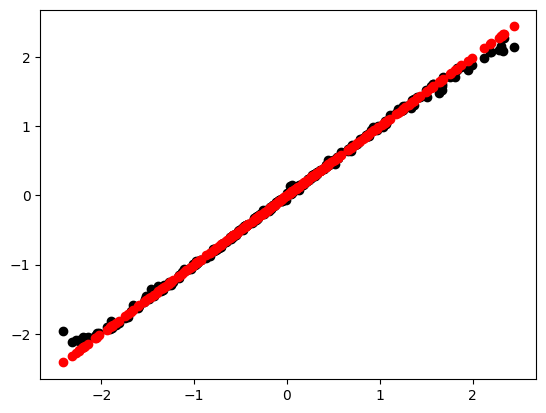

In [4]:
import matplotlib.pyplot as plt
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()

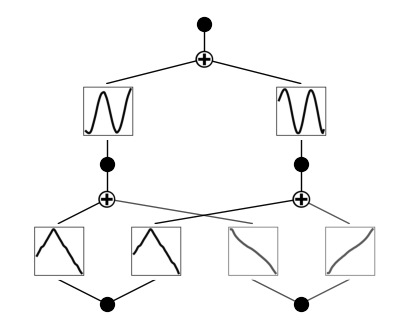

In [5]:
model.plot()

r2 is 0.9984984397888184
fixing (0,0,0) with abs, r2=1.0, c=3
r2 is 0.9981608986854553
fixing (0,0,1) with abs, r2=1.0, c=3
r2 is 0.9991335272789001
fixing (0,1,0) with tan, r2=1.0, c=3
r2 is 0.9994007349014282
fixing (0,1,1) with tan, r2=1.0, c=3
r2 is 0.9991938471794128
fixing (1,0,0) with cos, r2=1.0, c=2
r2 is 0.995557963848114
fixing (1,1,0) with sin, r2=1.0, c=2


| train_loss: 4.40e-03 | test_loss: 4.82e-03 | reg: 2.32e-01 | : 100%|█| 50/50 [00:36<00:00,  1.36it


0.0048186737
1.3916*sin(-1.1757*tan(0.4277*x_2 + 9.4198) + 0.39*Abs(9.2683*x_1 + 3.9315) + 6.2831) + 1.3924*cos(1.1931*tan(0.423*x_2 - 0.0053) + 0.4569*Abs(7.91*x_1 + 3.3556) + 1.5714) + 0.0226


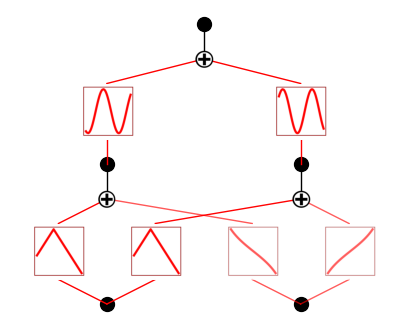

In [6]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0.5)
fit_kwargs_sym = {'opt': 'LBFGS', 'lr': 1, 'lamb': 0.01,
                  'lamb_entropy': 0.1, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5,}
fit_kwargs_sym['update_grid'] = False
res = model.fit(dataset, steps=50, **fit_kwargs_sym)
print(res['test_loss'][-1])

exp = ex_round(model.symbolic_formula()[0][0], 4)
print(exp)

model.plot()

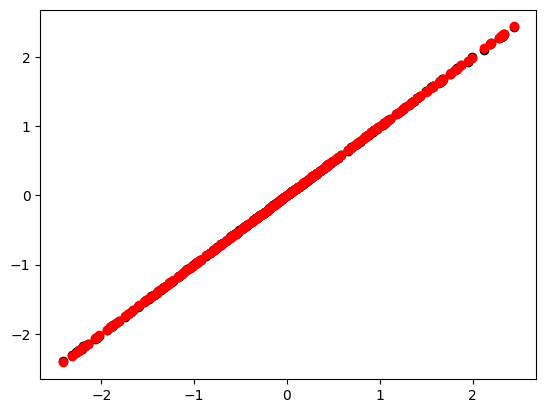

In [7]:
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()


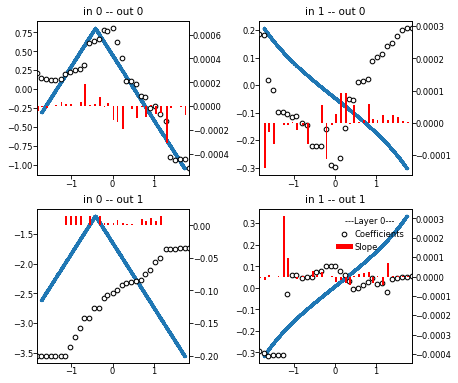

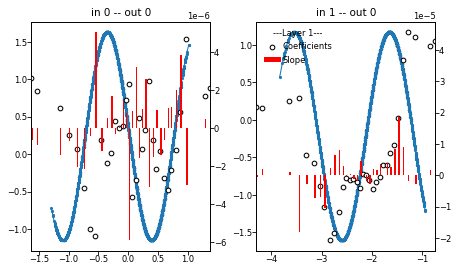

[<Figure size 450x375 with 8 Axes>, <Figure size 450x262.5 with 4 Axes>]

In [8]:
from kan.custom_processing import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

Text(0, 0.5, 'Attribution score')

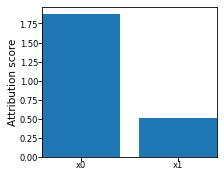

In [9]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

[tensor(1503), tensor(1497)]


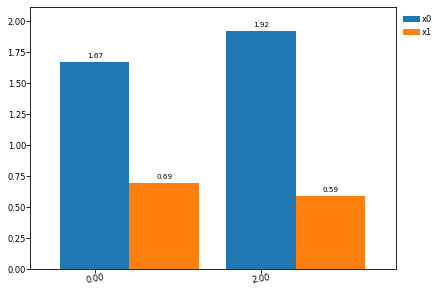

In [10]:
import numpy as np

mask_idx = 0
mask_interval = [-2, 0, 2]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

[tensor(644), tensor(844), tensor(900), tensor(612)]


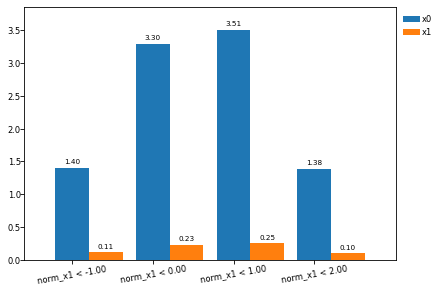

In [11]:
mask_idx = 1
mask_interval = [-2, -1, 0, 1, 2]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'norm_x{mask_idx} < {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

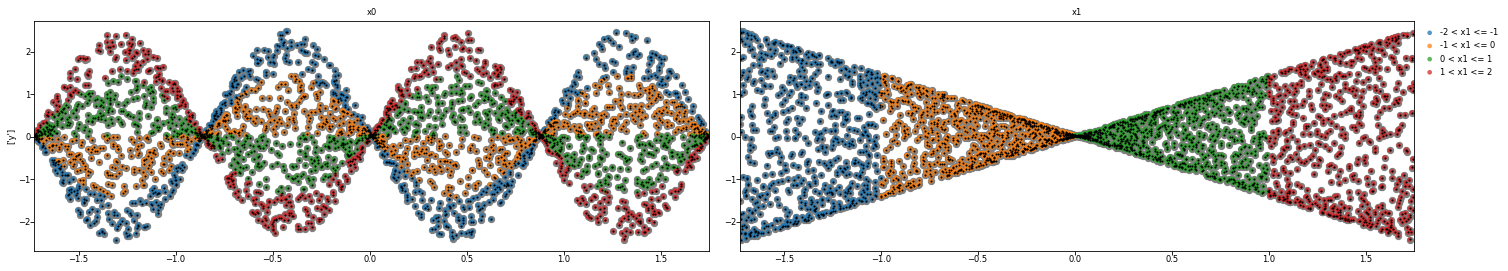

In [12]:
from kan.custom_processing import plot_data_per_interval
X = dataset['train_input'].detach().cpu().numpy()
y = dataset['train_label'].detach().cpu().numpy()
y_pred = model(dataset['train_input']).detach().cpu().numpy()

name_X = [f'x{idx}' for idx in range(X.shape[1])]
name_y = ['y']

fig_x1, ax_x1 = plot_data_per_interval(X, y, name_X, name_y, mask_idx, mask_interval)
for idx_x in range(X.shape[1]):
    ax_x1[idx_x].scatter(X[:, idx_x], y_pred, color='k', s=.9, label='Prediction')
plt.show()

In [13]:
from kan.experiments.multkan_hparam_sweep import mae_and_r2
_, _, test_mae, test_r2 = mae_and_r2(model, dataset['test_input'], dataset['test_label'])
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")

Test MAE: 0.0037
Test R2: 1.0000
